In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width: 80% !important; }</style>"))

In [3]:
import sys
import time
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib import colors

In [4]:
myColors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231',
            '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe',
            '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000',
            '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', 
            '#307D7E', '#000000', "#DDEFFF", "#000035", "#7B4F4B", 
            "#A1C299", "#300018", "#C2FF99", "#0AA6D8", "#013349", 
            "#00846F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", 
            "#1E6E00", "#DFFB71", "#868E7E", "#513A01", "#CCAA35"]

colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [5]:
import smashpy
sf = smashpy.smashpy()

 * Initialising ...



# Loading annData object

In [7]:
obj = sc.read_h5ad('../../../../External_datasets/mouse_brain_all_cells_20200625_with_annotations.h5ad')
obj.X = obj.X.toarray()

obj = obj[obj.obs["Cell sub annotation"]!="Unk_1"]
obj = obj[obj.obs["Cell sub annotation"]!="Unk_2"]
obj = obj[obj.obs["Cell sub annotation"]!="Ext_Unk_1"]
obj = obj[obj.obs["Cell sub annotation"]!="Ext_Unk_2"]
obj = obj[obj.obs["Cell sub annotation"]!="Ext_Unk_3"]

In [8]:
new_sub_annotation = []
for c in obj.obs["Cell sub annotation"].tolist():
    if c in ['Ext_Amy_1', 'Ext_Amy_2']:
        new_sub_annotation.append('Ext_Amy')
        
    elif c in ['Ext_Hpc_CA1', 'Ext_Hpc_CA2', 'Ext_Hpc_CA3']:
        new_sub_annotation.append('Ext_Hpc_CA')
        
    elif c in ['Ext_Hpc_DG1', 'Ext_Hpc_DG2']:
        new_sub_annotation.append('Ext_Hpc_DG')
        
    elif c in ['Ext_L5_1', 'Ext_L5_2', 'Ext_L5_3']:
        new_sub_annotation.append('Ext_L5')
        
    elif c in ['Ext_Thal_1', 'Ext_Thal_2']:
        new_sub_annotation.append('Ext_Thal')
        
    elif c in ['Inh_1', 'Inh_2', 'Inh_3', 'Inh_4', 'Inh_5', 'Inh_6']:
        new_sub_annotation.append('Inh')
        
    elif c in ['Inh_Meis2_1', 'Inh_Meis2_2', 'Inh_Meis2_3', 'Inh_Meis2_4']:
        new_sub_annotation.append('Inh_Meis2')
        
    elif c in ['Astro_AMY', 'Astro_AMY_CTX', 'Astro_CTX']:
        new_sub_annotation.append('Astro_AMY_CTX')
        
    elif c in ['Astro_THAL_hab', 'Astro_THAL_lat', 'Astro_THAL_med']:
        new_sub_annotation.append('Astro_THAL')
        
    elif c in ['LowQ_1', 'LowQ_2']:
        new_sub_annotation.append('LowQ')
        
    elif c in ['Nb_1', 'Nb_2']:
        new_sub_annotation.append('Nb')
    
    elif c in ['OPC_1', 'OPC_2']:
        new_sub_annotation.append('OPC')
    
    elif c in ['Oligo_1', 'Oligo_2']:
        new_sub_annotation.append('Oligo')

    else:
        new_sub_annotation.append(c)
obj.obs["Cell sub annotation"] = new_sub_annotation
obj.obs["Cell sub annotation"] = obj.obs["Cell sub annotation"].astype("category")

Trying to set attribute `.obs` of view, copying.


In [9]:
print("%d genes across %s cells"%(obj.n_vars, obj.n_obs))

31053 genes across 38872 cells


#### Data preparation

In [10]:
sf.data_preparation(obj)

#### Removing general genes

In [11]:
s1 = time.time()

In [12]:
obj = sf.remove_general_genes(obj, species='mouse')

#### Removing house-keeping genes

http://www.housekeeping.unicamp.br/?homePageGlobal

In [13]:
obj = sf.remove_housekeepingenes(obj, path="../../data/house_keeping_genes_Mouse_cortex.txt")

#### Removing genes expressed in less than 30% within groups

In [14]:
obj = sf.remove_features_pct(obj, group_by="Cell sub annotation", pct=0.3)

#### Removing genes expressed in more than 50% in a given group where genes are expressed for more 75% within a given group

In [15]:
obj = sf.remove_features_pct_2groups(obj, group_by="Cell sub annotation", pct1=0.75, pct2=0.5)

#### Revert PCA

In [16]:
obj = sf.scale_filter_features(obj, n_components=None, filter_expression=True)

Fraction passing PCA: 0.9384991843393149


In [17]:
obj.var.set_index(obj.var["SYMBOL"], inplace=True, drop=False)
obj.var.index.name = None

#### DNN

In [18]:
s2 = time.time()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                184128    
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
activation (Activation)      (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0

<Figure size 432x288 with 0 Axes>

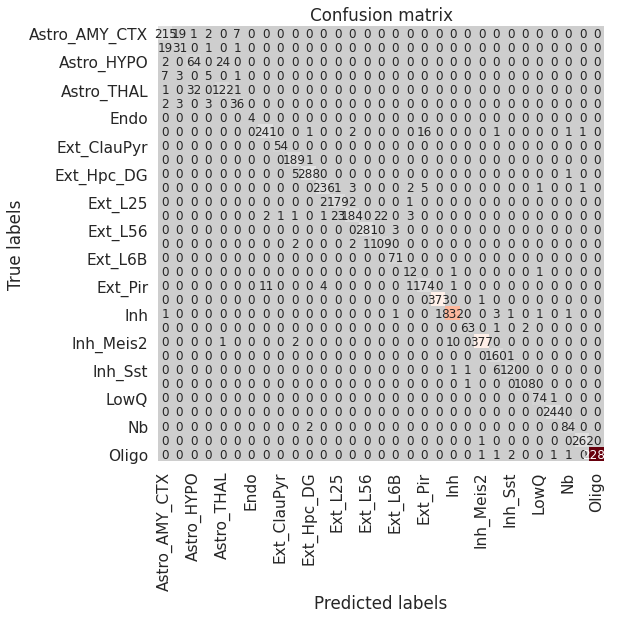

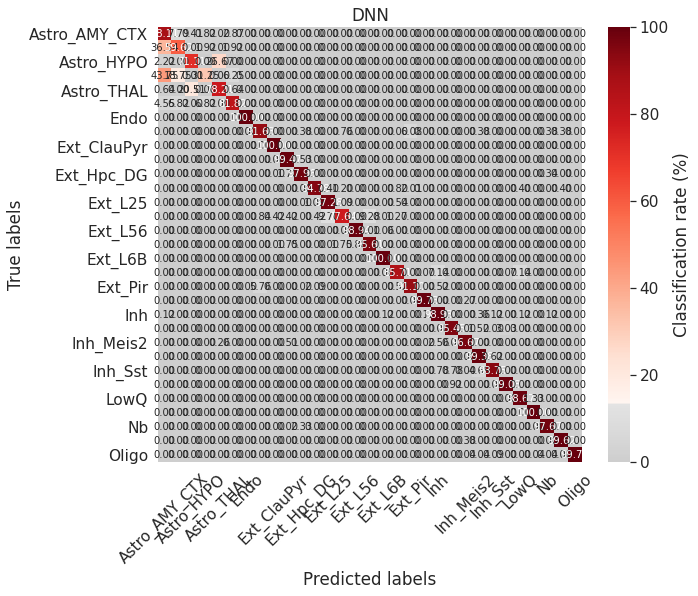

               precision    recall  f1-score   support

Astro_AMY_CTX       0.87      0.88      0.88       244
    Astro_HPC       0.55      0.60      0.57        52
   Astro_HYPO       0.66      0.71      0.68        90
    Astro_STR       0.45      0.31      0.37        16
   Astro_THAL       0.83      0.78      0.81       156
     Astro_WM       0.78      0.82      0.80        44
         Endo       1.00      1.00      1.00         4
      Ext_Amy       0.95      0.92      0.93       263
  Ext_ClauPyr       0.98      1.00      0.99        54
   Ext_Hpc_CA       0.95      0.99      0.97       190
   Ext_Hpc_DG       0.99      0.98      0.98       294
      Ext_L23       0.97      0.95      0.96       249
      Ext_L25       0.88      0.97      0.93       184
       Ext_L5       0.95      0.78      0.86       237
      Ext_L56       1.00      0.99      0.99       284
       Ext_L6       0.83      0.96      0.89       114
      Ext_L6B       0.95      1.00      0.97        71
      Ext

In [19]:
sf.DNN(obj, group_by="Cell sub annotation", model=None, balance=True, verbose=True, save=True)

####Â Shap value

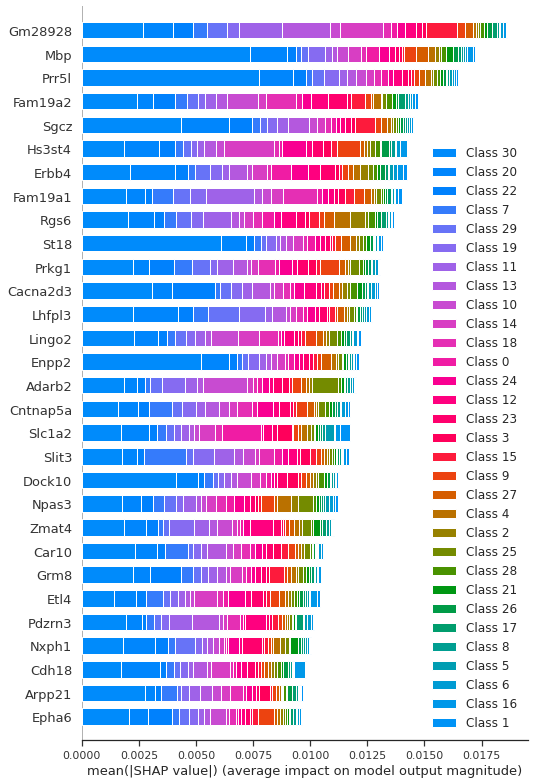

In [20]:
selectedGenes, selectedGenes_dict = sf.run_shap(obj, group_by="Cell sub annotation", model=None, verbose=True, pct=0.1, restrict_top=("local", 20))

In [21]:
e2 = time.time()

#### Classifiers

<Figure size 432x288 with 0 Axes>

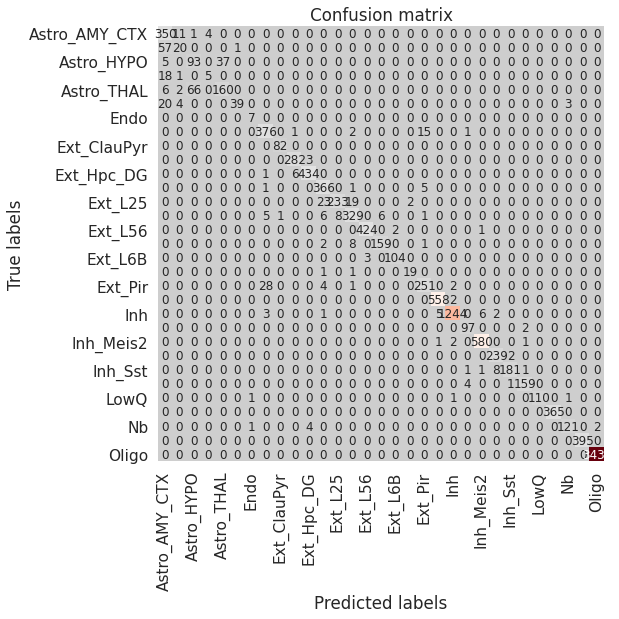

Accuracy: 0.9614131366832447: Misclassification: 0.038586863316755315
               precision    recall  f1-score   support

Astro_AMY_CTX       0.77      0.96      0.85       366
    Astro_HPC       0.53      0.26      0.34        78
   Astro_HYPO       0.58      0.69      0.63       135
    Astro_STR       0.56      0.21      0.30        24
   Astro_THAL       0.81      0.68      0.74       234
     Astro_WM       0.97      0.59      0.74        66
         Endo       0.78      1.00      0.88         7
      Ext_Amy       0.91      0.95      0.93       395
  Ext_ClauPyr       0.99      1.00      0.99        82
   Ext_Hpc_CA       0.98      0.99      0.98       285
   Ext_Hpc_DG       0.98      0.98      0.98       441
      Ext_L23       0.91      0.98      0.94       373
      Ext_L25       0.97      0.84      0.90       277
       Ext_L5       0.91      0.92      0.92       356
      Ext_L56       0.99      0.99      0.99       427
       Ext_L6       0.96      0.94      0.95     

In [22]:
sf.run_classifiers(obj, group_by="Cell sub annotation", genes=selectedGenes, classifier="KNN", balance=True, title="DNN-KNN", save=True)

#### Sorting genes per cluster

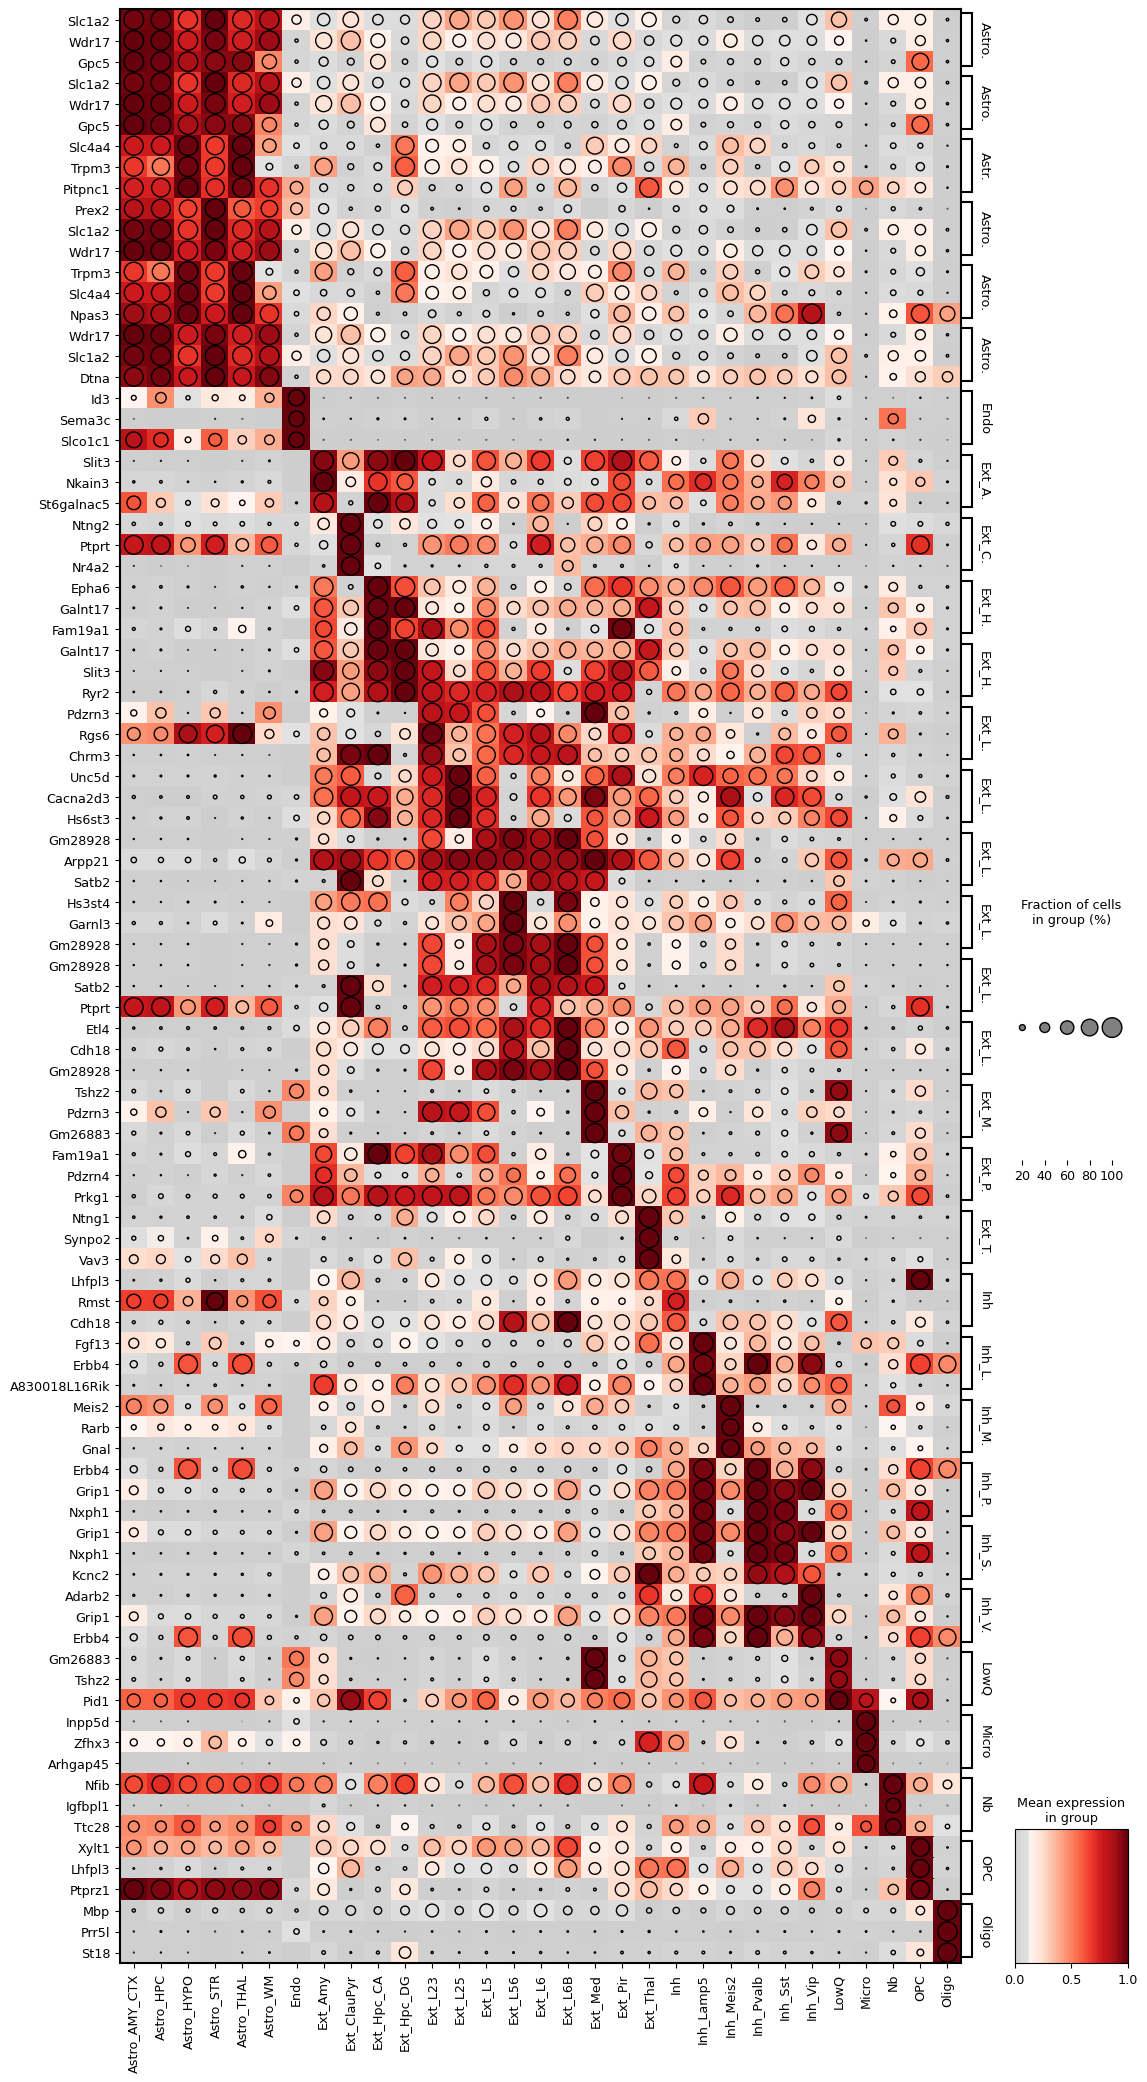

In [23]:
axs, selectedGenes_top_dict = sf.sort_and_plot(obj, selectedGenes, group_by="Cell sub annotation", top=3, figsize=(13,25))

In [24]:
e1 = time.time()

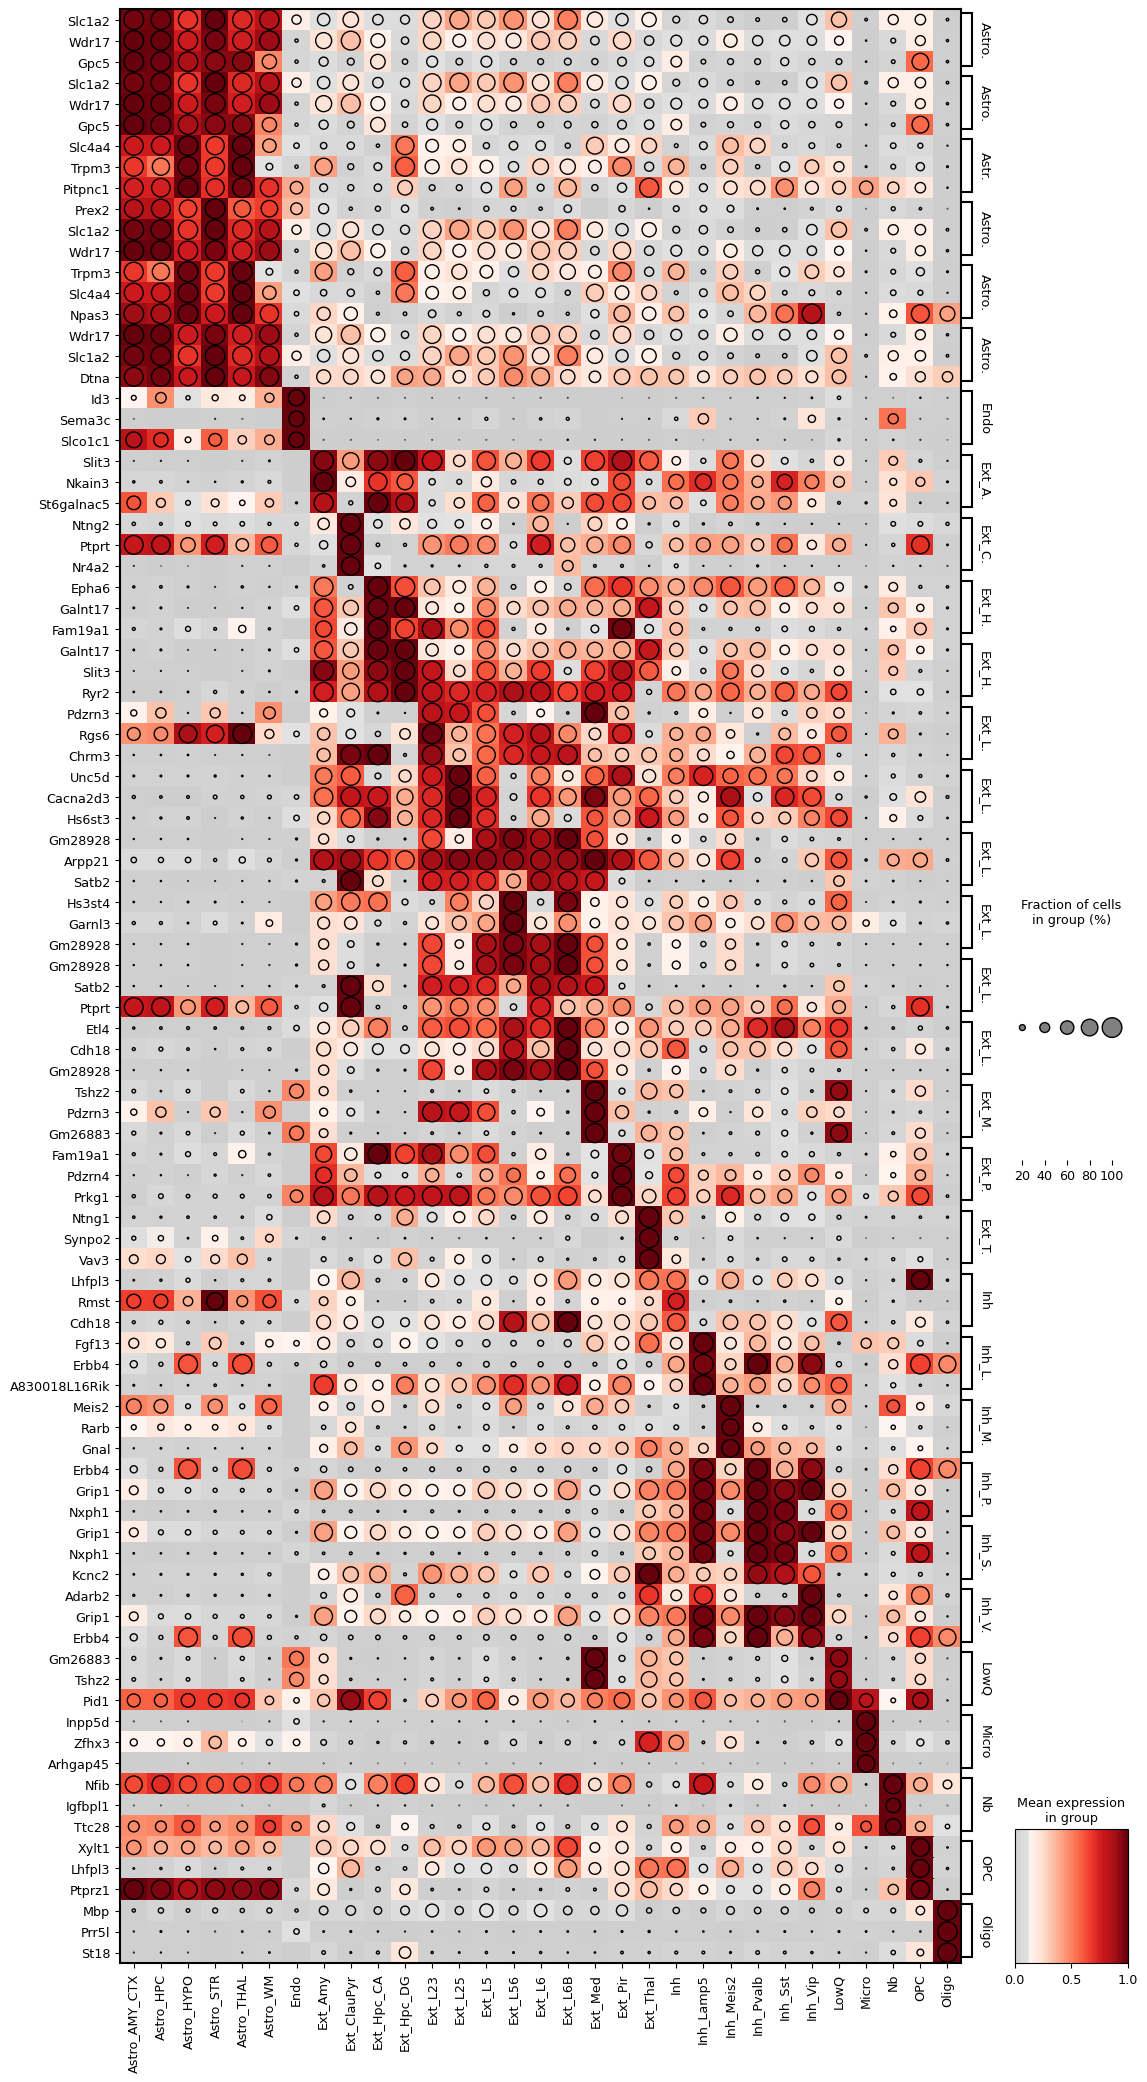

In [25]:
axs.savefig("Figures/DNN_top5_perGroup.pdf")

# Elapsed time

In [26]:
print("%d genes across %s cells"%(obj.n_vars, obj.n_obs))

5753 genes across 38872 cells


In [27]:
print('Elapsed time (s): ', e1-s1)

Elapsed time (s):  27371.969893932343


In [28]:
print('Elapsed time (s): ', e2-s2)

Elapsed time (s):  26218.69275522232
